# Data Analysis Stage and Visualisation

## Libraries and directories

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
import json
from scipy.stats import pointbiserialr

In [20]:
# Directory for transformed data
transformed_data_path = './Transformed_data/'

# Set seed
seed = 2024

In [21]:
# Define description of variables to improve plotting

variables_index = {
    'Diff_ranking':'ATP Ranking',
    'Diff_log_ranking':'ATP Ranking',
    'Diff_ranking_points':'ATP Points',
    'Diff_log_ranking_points':'ATP Points',
    'Diff_Elo':'Elo Ranking',
    'Diff_log_Elo':'Elo Ranking',
    'Diff_tournaments_played':'GS Tournaments',
    'Diff_GS_matches':'GS Matches',
    'Diff_Max_round':'Max Round',
    'Diff_minutes':'Minutes',
    'Diff_prev_sets':'Sets',
    'Diff_prev_games':'Games',
    'Diff_age':'Age',
    'Diff_height':'Height',
    'Prev_Champ_Ind':'Champion Ind',
    'Hand_Type':'Player Hand',
    'Court_Type':'Court Type',
    'Hard':'Surface Hard',
    'Grass':'Surface Grass',
    'Right-handed':'Right-Handed',
    'Previous_champion': 'Prev Champion' }

## Load pre-processed data

In [22]:
#Load dataset
full_db_prep =  pd.read_pickle(transformed_data_path+'tennis_db_preprocessed.pkl')
print(full_db_prep.shape)
#full_db_prep.info()

### Define variables for analysis
target = ['Win_indicator']
numerical_variables = [x for x in list(full_db_prep.columns) if 'Diff' in x ]
categorical_variables = ['Prev_Champ_Ind','Hand_Type','Court_Type']

(13081, 63)


## Univariate Analysis

### Support functions

In [23]:
# Histogram visualisation to review distribution for numeric variables
def plot_hist_numeric_var(db,col_name):
    db_2 = db.dropna(subset= [col_name] ) #remove missing values
    plt.figure(figsize=(6, 4))
    plt.hist(db_2[col_name], color = 'Darkblue')
    plt.xlabel("Value", size = 12)
    plt.ylabel("Count", size = 12)
    plt.title(f"Histogram for {variables_index[col_name]}")
    sns.despine()
    plt.show()


# Box plot visualisation for numerical variables to detect general outliers
def plot_boxplot(db,col_name):
    db_2 = db.dropna(subset= [col_name] ) #remove missing values
    plt.figure(figsize=(6, 4))
    plt.boxplot(db_2[col_name], vert = True)
    plt.xlabel("Box", size = 12)
    plt.xticks([])
    sns.despine()
    plt.ylabel("Value", size = 12)
    plt.title(f"Boxplot for {variables_index[col_name]}")
    plt.show()


# Bar plot visualisation for categorical variables
def plot_bar_categorical_var(db,col_name):
    count_data = db[col_name].value_counts().reset_index() #create data with counts
    
    plt.figure(figsize=(6, 4))
    plt.bar(x=count_data[col_name],height= count_data['count'], color = 'Darkgreen')
    plt.xlabel("Category", size = 12)
    plt.ylabel("Count", size = 12)
    plt.title(f"Bar Plot for {variables_index[col_name]}")
    sns.despine()
    plt.show()

# Function to count for columns with missings
def missing_count(db):
    # Filter columns with missing values > 0
    missing_df = db.isna().sum().reset_index().rename(columns={'index': 'column', 0: 'missing_count'})
    missing_df = missing_df[missing_df['missing_count'] > 0]
    missing_df['%missing'] = [round(x*100/len(db),2) for x in missing_df['missing_count']]
    print(missing_df)

### Missing count

In [24]:
missing_count(full_db_prep[numerical_variables+categorical_variables])

          column  missing_count  %missing
9   Diff_minutes            263      2.01
13   Diff_height             32      0.24


Only minutes and height have missing values with a minor % of missing, the median will be imputed for them instead of removing the rows

### Summary statistics

In [25]:
full_db_prep[numerical_variables].describe()

,Diff_Max_round,Diff_tournaments_played,Diff_GS_matches,Diff_ranking,Diff_log_ranking,Diff_ranking_points,Diff_log_ranking_points,Diff_Elo,Diff_log_Elo,Diff_minutes,Diff_prev_sets,Diff_prev_games,Diff_age,Diff_height
count,13081.000000,13081.000000,13081.000000,13081.000000,13081.000000,13081.000000,13081.000000,13081.000000,1.308100e+04,12818.000000,13081.000000,13081.000000,13081.000000,13049.000000
mean,0.003746,-0.096934,-0.658054,-0.832582,0.002015,-16.415641,-0.000788,-1.168082,-6.690527e-04,-0.627477,-0.011849,-0.152664,0.029172,-0.040463
std,2.724490,21.109263,82.848469,156.604260,1.794620,2770.709418,1.382777,210.232079,1.231680e-01,66.808223,1.167644,14.500248,5.449543,9.629258
min,-7.000000,-76.000000,-411.000000,-1846.000000,-7.222566,-16641.000000,-8.834191,-811.912972,-4.451636e-01,-487.000000,-8.000000,-106.000000,-20.900000,-38.000000
25%,-2.000000,-13.000000,-36.000000,-48.000000,-1.193278,-834.000000,-0.890854,-117.717415,-7.326909e-02,0.000000,0.000000,0.000000,-3.600000,-7.000000
50%,0.000000,0.000000,0.000000,1.000000,0.019545,-5.000000,-0.006719,-0.000244,-1.645637e-07,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,13.000000,35.000000,49.000000,1.220902,796.000000,0.876208,114.926382,7.226192e-02,0.000000,0.000000,0.000000,3.700000,6.000000
max,7.000000,77.000000,422.000000,1844.000000,6.388561,15969.000000,8.741935,778.847662,4.263991e-01,533.000000,9.000000,119.000000,18.700000,35.000000


### Univariate visualisations for variables

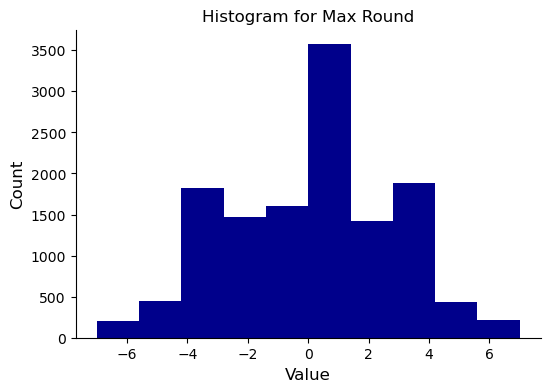

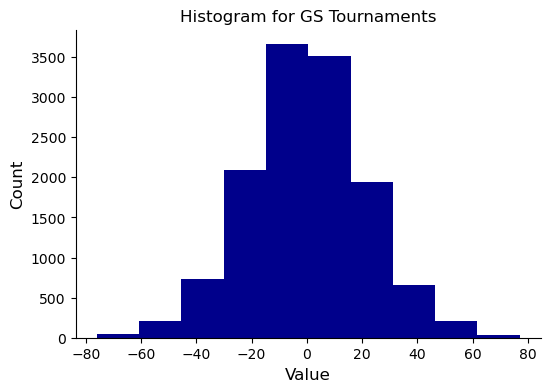

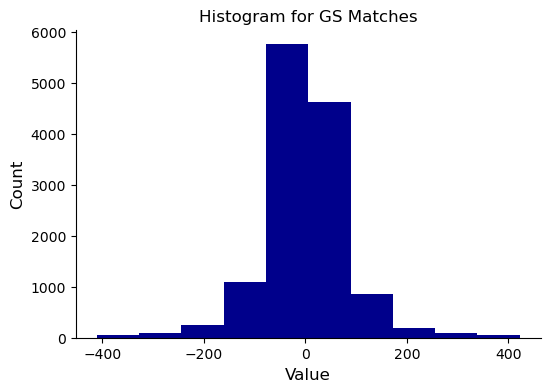

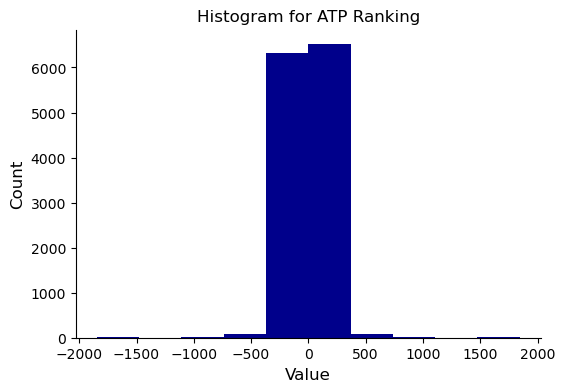

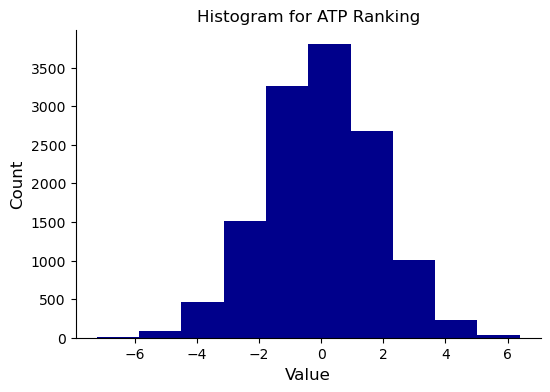

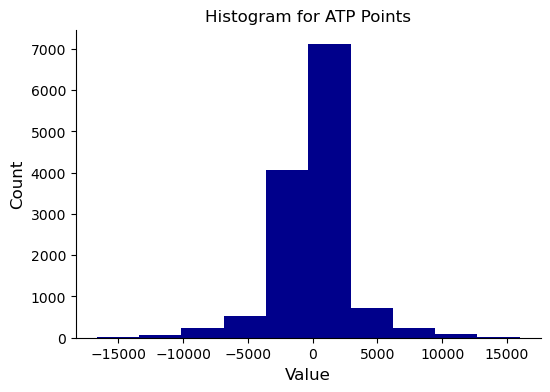

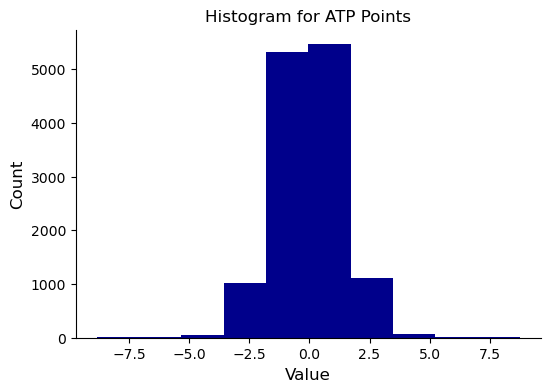

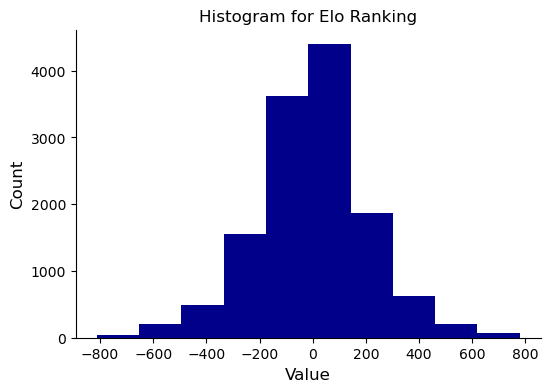

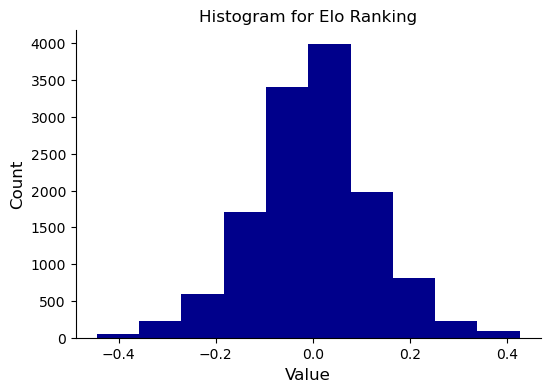

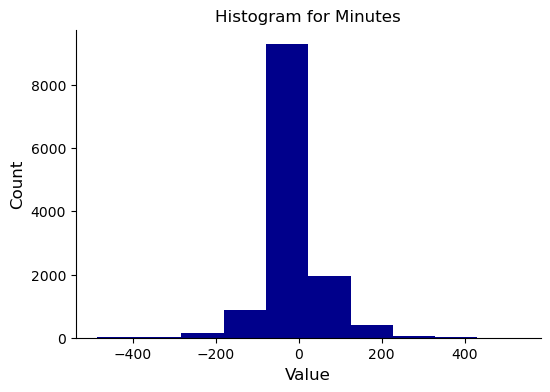

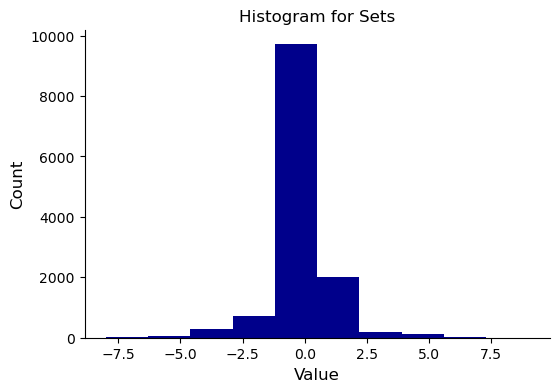

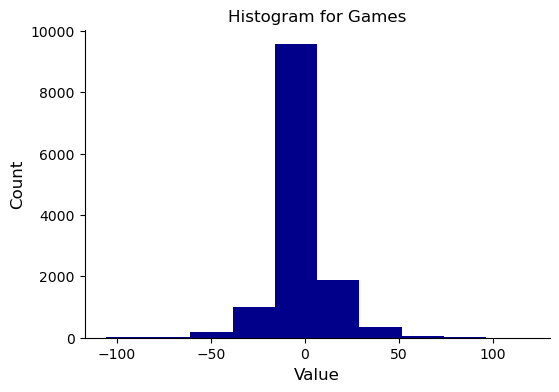

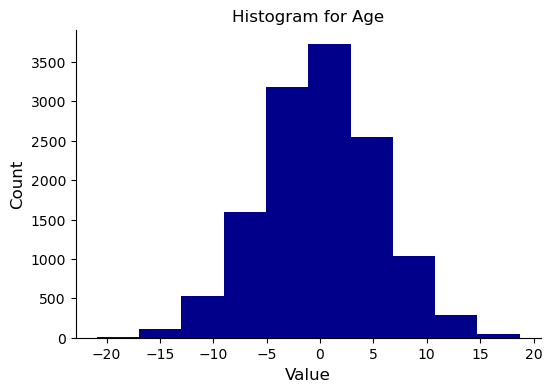

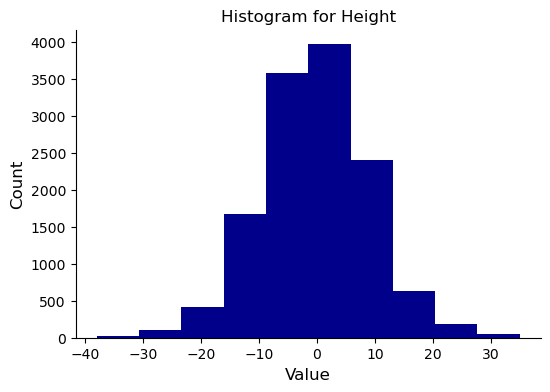

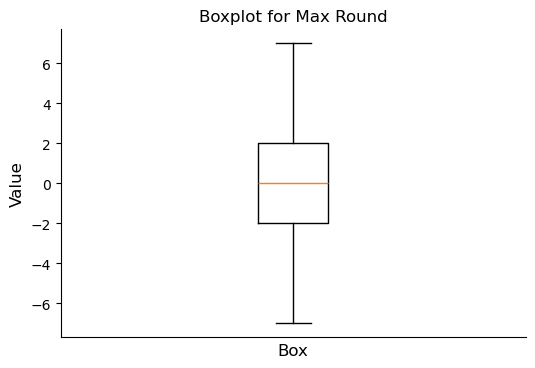

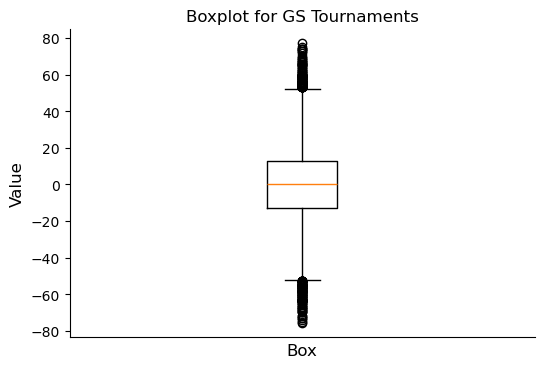

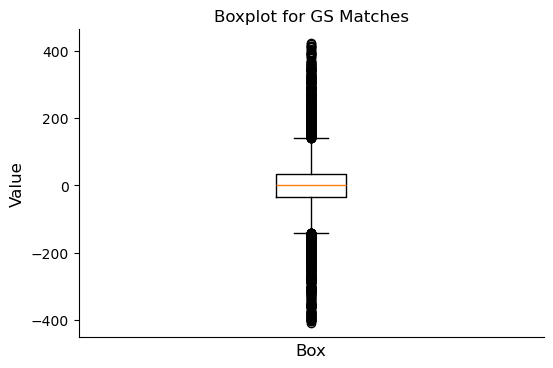

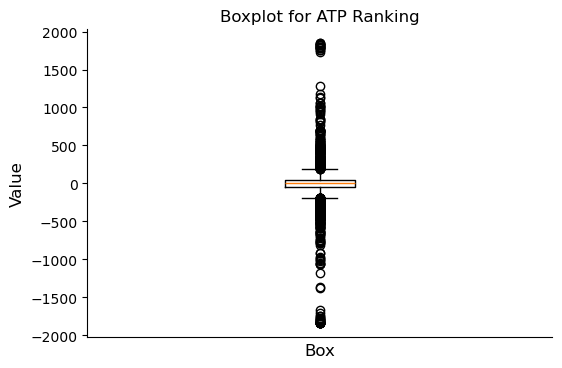

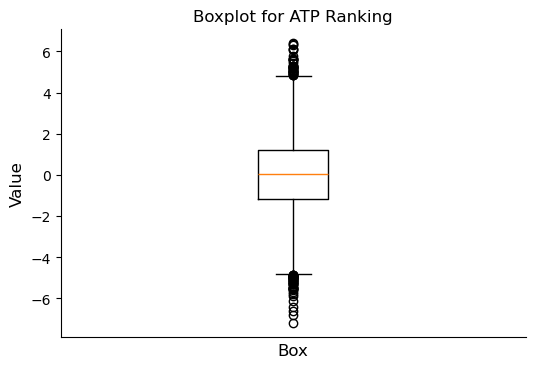

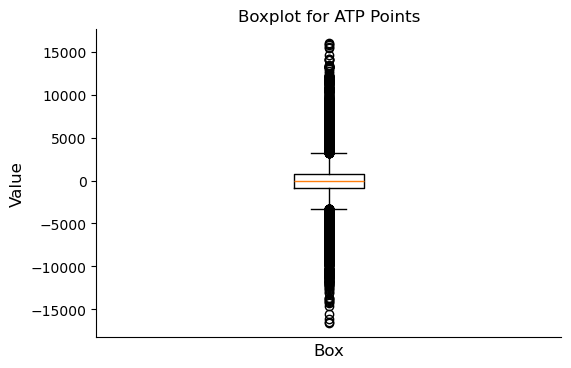

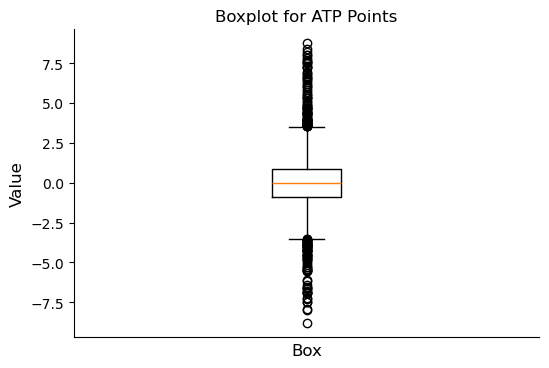

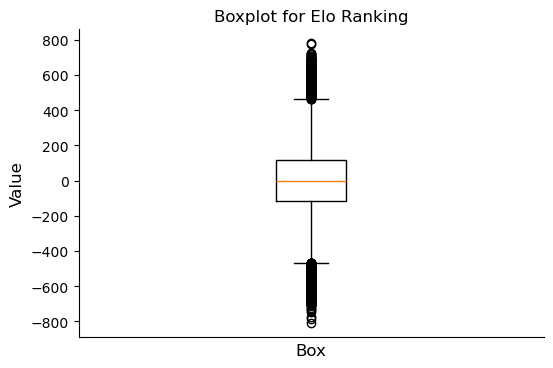

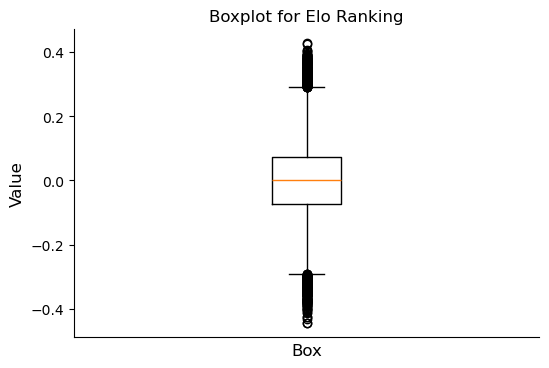

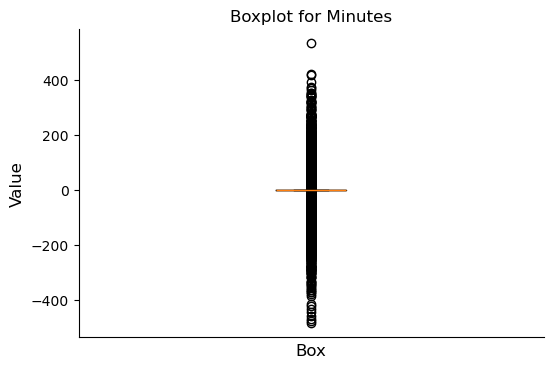

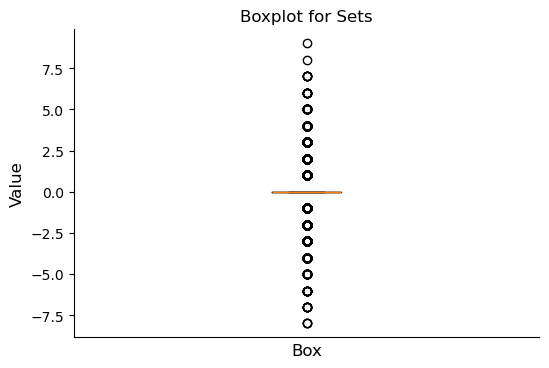

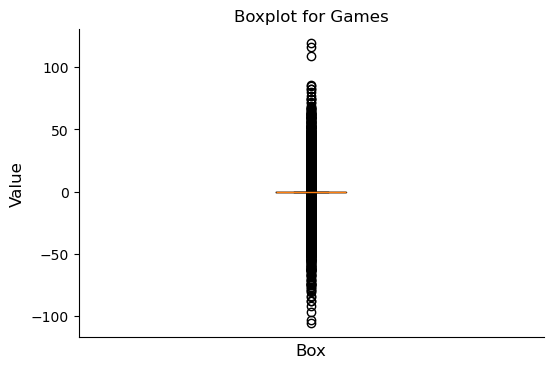

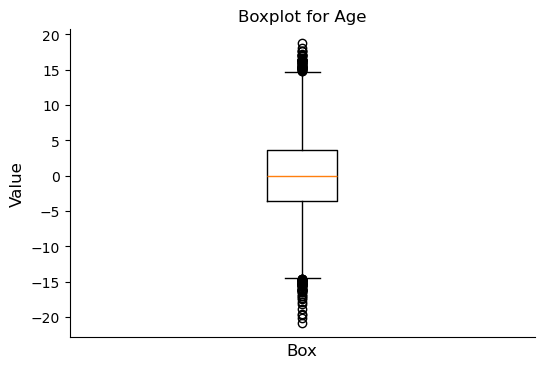

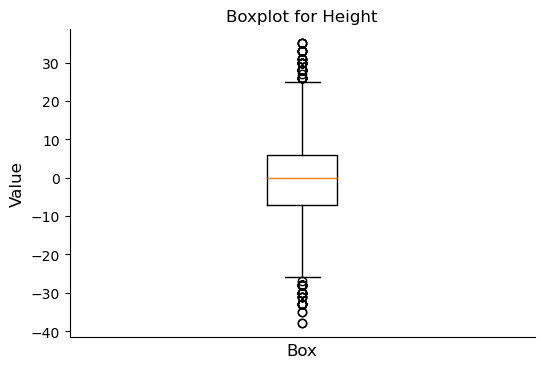

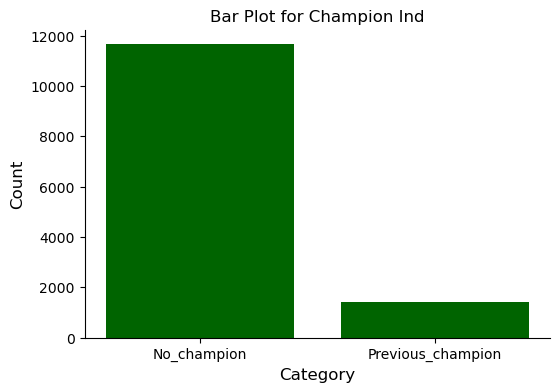

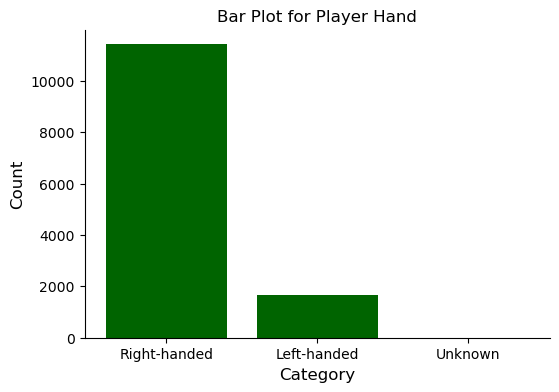

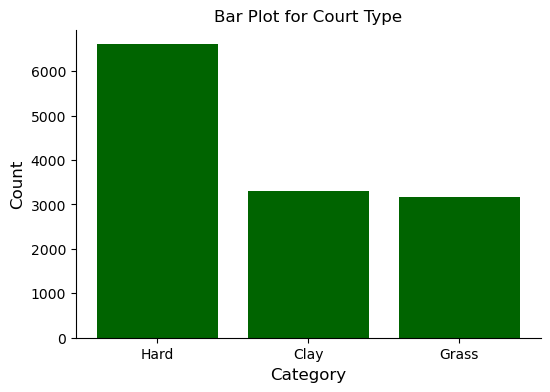

In [26]:
## Plots for all variables

# Histogram distribution for numerical variables
for col in numerical_variables:
    plot_hist_numeric_var(full_db_prep, col)

# Boxplots for numerical variables
for col in numerical_variables:
    plot_boxplot(full_db_prep,col)

# Bar charts for categorical variables
for col in categorical_variables:
    plot_bar_categorical_var(full_db_prep,col)

**Conclusion for numerical variables:** As can be seen, there are some outliers but these values seems to be within the expected range and hence they are not invalid values. Furthermore, the ranking variables showed some dispersion, however, this variation seems to stabilize after applying a log transformation. For other variables, the dispersion does not seem so strong. Finally, in general all numerical variables seems to be unimodal and concentrated in the middle, indicating they are symmetrically distributed.
In any case, normal standardization will be performed to all variables before modeling to ensure they are on the same scale.

**Conclusion for categorical variables:** 
- Previous champion indicator: There are very few cases which were previous champions. Hence this unbalaced variable could be not good for modelling.
- Player hand: Similarly, there are very few left-handed players. Furthemore, some cases are missing (Unknown). For these cases, the most common category (Right-handed) will be imputed.
- Court type: Hard surface is the most common category, followed by Clay and then Grass types.

## Bivariate Analysis

### Support functions

In [27]:
# Function to create bins for numerical variables (for visualisation)
def numeric_binning(db,target,bins,variable):
        db_ax = db.copy()
        db_ax['metric_to_review'] = pd.qcut(db_ax[variable],bins, retbins=False, precision=4, duplicates='drop')

        db_summary = db_ax.groupby('metric_to_review',observed=False)[target].aggregate(['count','mean']).reset_index()
        db_summary.columns = [variable,'Cases','WR']
    
        #Convert intervals to show -inf and inf at extremes
        intervals = db_summary[variable]
        
        # Replace first left bound and last right bound
        intervals = intervals.map(lambda x: pd.Interval(
                left=float('-inf') if x.left == intervals.min().left else x.left,
                right=float('inf') if x.right == intervals.max().right else x.right,
                closed=x.closed))


        # Show integer format or decimal format
        def format_number(x):
            y = int(x) if db[variable][0].is_integer() else round(x,1)
            return y
    
        #Build labels showing -inf / inf properly for bins, compute Winner Rate WR for each bin
        db_summary['UB'] = [ f"({ '-∞' if np.isneginf(x.left) else format_number(x.left) },{ '∞' if
                                    np.isposinf(x.right) else format_number(x.right) }]" for x in intervals ]
        db_summary['WR'] = db_summary['WR'].fillna(0)        
        db_summary['Winners'] = db_summary['Cases']*db_summary['WR']
        db_summary['Winners'] = [round(x,0) for x in db_summary['Winners']]       
        db_summary = db_summary[[variable,'Cases','Winners','WR','UB']]
        
        return db_summary

# Plot of numeric variable vs target, by bin distribution
def wr_distribution_numeric(db,Target,bins,variable):
    
    db_b = numeric_binning(db,Target,bins,variable)
    y = db_b['WR'] # WInner rate
    x = db_b.index #xvalues
    avg_wr = np.mean(db[Target])

    labels = [str(x) for x in db_b['UB']] #labels for xvalues
    counts = db_b['Cases'] #cases
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5)

    ax1.bar(x,counts,color='#F4F6F7')
    ax1.set_ylabel('Cases',fontdict={'family':'arial','color':'black','size':12})
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels,size=9)
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #for i in range(len(counts)):
    #    ax1.annotate(str(f'{counts[i]:,}'), xy=(x[i],0), ha='center', va='bottom',textcoords="offset points",size=10,xytext=(0,0))

    ax2 = ax1.twinx()
    ax2.plot(y,marker='o',linestyle='-',color='darkred',label='WR',alpha=.7)  #plot
    ax2.set_ylabel('% Winner Rate',fontdict={'family':'arial','color':'black','size':12}) #ylabel
    plt.ylim(0,1) #y axis limit
    rot_set_xlabel = 0 #argument for xlabels
    ax2.set_xticklabels(labels,rotation=rot_set_xlabel,size=10) #xlabes
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0)) #y axis as %
    ax2.axhline(y=avg_wr,color="gray",linestyle=':',label='Avg WR',alpha=.5) #avg WR
    ax2.legend()

    #Remove top border (spine)
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    #Axis x title
    ax1.set_xlabel('Values', fontdict={'family': 'arial', 'color': 'black', 'size': 12})

    for x,y in zip(x,y): #data values
        label = "{:.0%}".format(y)
        ax2.annotate(label,(x,y),textcoords="offset points",
                     xytext=(0,6),
                     ha='left')
    plt.title(f'Distribution of Winner Rate by {variables_index[variable]}',size=13) #chart title
    fig.tight_layout()
    #fig.savefig("wr_distribution.png",dpi=200)
    #plt.close()
    plt.show()

# Compute bins for categorical predictors
def categoric_binning(db,target,variable):
        db_summary = db.groupby(variable)[target].aggregate(['count','mean']).reset_index()
        db_summary.columns = [variable,'Cases','WR']
        db_summary['WR'] = db_summary['WR'].fillna(0)
        db_summary['Winners'] = db_summary['Cases']*db_summary['WR']
        db_summary['Winners'] = [round(x,0) for x in db_summary['Winners']]
        db_summary = db_summary[[variable,'Cases','Winners','WR']]
        return db_summary

# Plot of categorical variable vs target, by each category
def wr_distribution_categoric(db,Target,variable):
    
    bin_db = categoric_binning(db,Target,variable)
    y = bin_db['WR'] #WR
    x = bin_db.index #xvalues
    labels = [str(x) for x in bin_db[variable]] #labels for xvalues
    counts = bin_db['Cases'] #cases
    avg_wr = np.mean(db[target])

    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5)
    ax1.bar(x,counts,color='#F4F6F7')
    ax1.set_ylabel('Cases',fontdict={'family':'arial','color':'black','size':12})
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels,size=10)
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #for i in range(len(counts)):
    #    ax1.annotate(str(f'{counts[i]:,}'), xy=(x[i],0), ha='center', va='bottom',textcoords="offset points",size=10,xytext=(0,0))

    ax2 = ax1.twinx()
    ax2.plot(y,marker='o',linestyle='-',color='darkred',label='WR',alpha=.7)  #plot
    ax2.set_ylabel('% Winner Rate',fontdict={'family':'arial','color':'black','size':12}) #ylabel
    plt.ylim(0,1) #y axis limit
    rot_set_xlabel = 0 #argument for xlabels
    ax2.set_xticklabels(labels,rotation=rot_set_xlabel,size=10) #xlabes
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0)) #y axis as %
    ax2.axhline(y=avg_wr,color="gray",linestyle=':',label='Avg WR',alpha=.5) #avg WR
    ax2.legend()

    #Remove top border (spine)
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    #Axis x title
    ax1.set_xlabel('Values', fontdict={'family': 'arial', 'color': 'black', 'size': 12})

    for x,y in zip(x,y): #data values
        label = "{:.0%}".format(y)
        ax2.annotate(label,(x,y),textcoords="offset points",
                     xytext=(0,6),
                     ha='left')

    plt.title(f'Distribution of Winner Rate by {variables_index[variable]}',size=13) #chart title
    fig.tight_layout()
    #fig.savefig("wr_distribution_disc.png",dpi=200)
    #plt.close()
    plt.show()

#Plot for matrix of correlations
def corr_function(db):
    corr_df = db.corr().round(2)
    max_corr = 0.4
    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] =  1

    with sns.axes_style("white"):
        f,ax = plt.subplots(figsize=(15,15))
        ax = sns.heatmap(corr_df,vmax=max_corr,mask=mask,square=True,annot=True,cmap='YlGnBu')

#### Correlation among predictors within same category

In [28]:
#Define categories for predictors
cat_ranking = ['Diff_log_ranking','Diff_log_ranking_points','Diff_log_Elo']
cat_experience = ['Diff_Max_round','Diff_tournaments_played','Diff_GS_matches']
cat_stamina = ['Diff_minutes','Diff_prev_sets','Diff_prev_games']

all_categories = [cat_ranking,cat_experience,cat_stamina]

#Print matrix correlations for predictors by category
for cat in all_categories:
    print(full_db_prep[cat].corr().round(2))

                         Diff_log_ranking  Diff_log_ranking_points  \
Diff_log_ranking                     1.00                    -0.96   
Diff_log_ranking_points             -0.96                     1.00   
Diff_log_Elo                        -0.78                     0.72   

                         Diff_log_Elo  
Diff_log_ranking                -0.78  
Diff_log_ranking_points          0.72  
Diff_log_Elo                     1.00  
                         Diff_Max_round  Diff_tournaments_played  \
Diff_Max_round                     1.00                     0.69   
Diff_tournaments_played            0.69                     1.00   
Diff_GS_matches                    0.68                     0.87   

                         Diff_GS_matches  
Diff_Max_round                      0.68  
Diff_tournaments_played             0.87  
Diff_GS_matches                     1.00  
                 Diff_minutes  Diff_prev_sets  Diff_prev_games
Diff_minutes             1.00            0.84      

Variables within the same category are highly correlated

#### Correlation of numerical predictors vs target

In [29]:
def biserall_corr(db, target, predictor):
    db_val = db[~db[predictor].isnull()]
    correlation, p_value = pointbiserialr(db_val[target], db_val[predictor])
    return round(correlation,2)#{'r':round(correlation,2), 'p-val':round(p_value,2)}

correlations = {}
for predictor in numerical_variables:
    correlations[predictor] = biserall_corr(full_db_prep, target[0], predictor)

# To represent as a Series
point_biserial_series = pd.Series(correlations, name=f'Biseral-correlation with {target[0]}')
correlation_df = pd.DataFrame(point_biserial_series).T
correlation_df

,Diff_Max_round,Diff_tournaments_played,Diff_GS_matches,Diff_ranking,Diff_log_ranking,Diff_ranking_points,Diff_log_ranking_points,Diff_Elo,Diff_log_Elo,Diff_minutes,Diff_prev_sets,Diff_prev_games,Diff_age,Diff_height
Biseral-correlation with Win_indicator,0.4,0.23,0.32,-0.27,-0.49,0.42,0.47,0.45,0.45,-0.16,-0.15,-0.17,-0.02,0.1


Variables show good potential correlation with target

#### Bivariate distributions plots

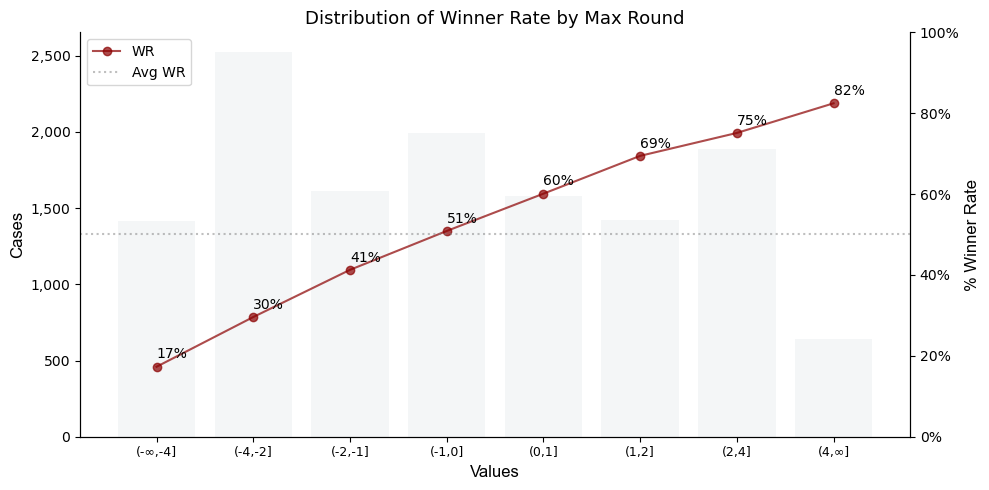

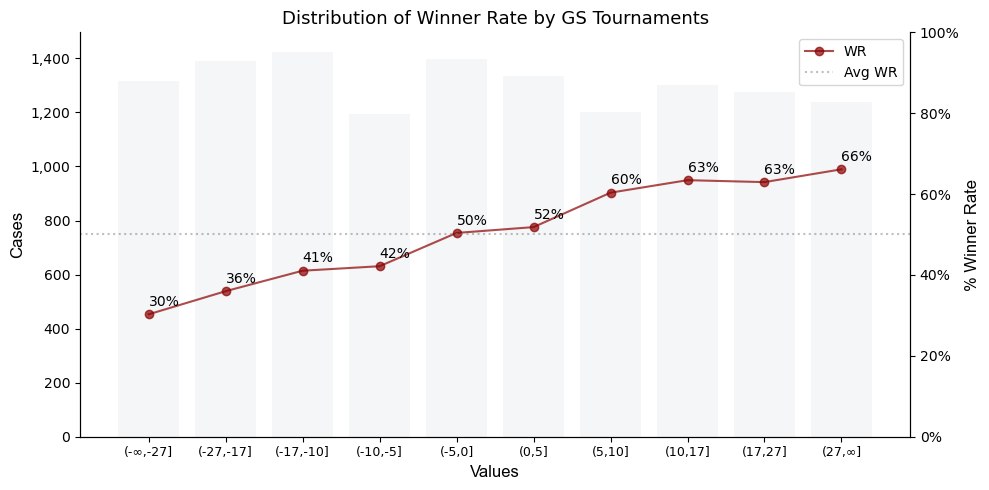

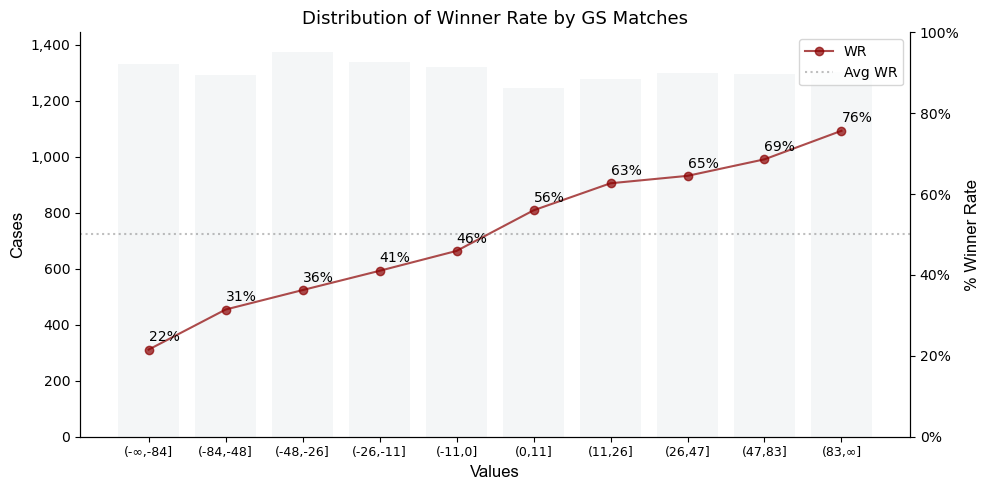

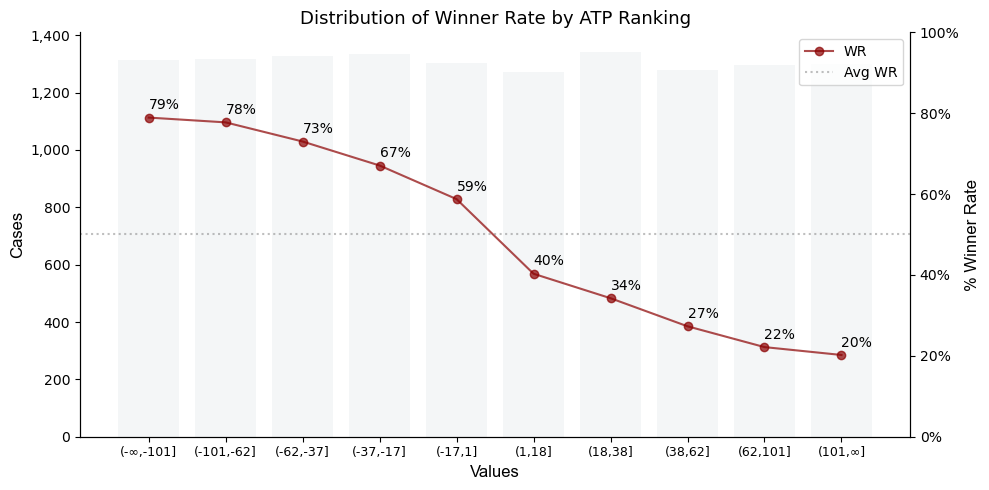

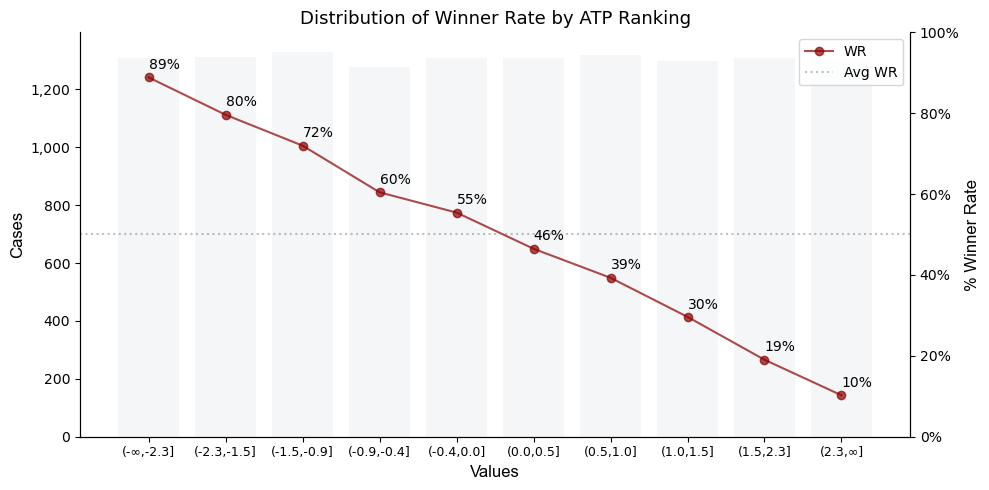

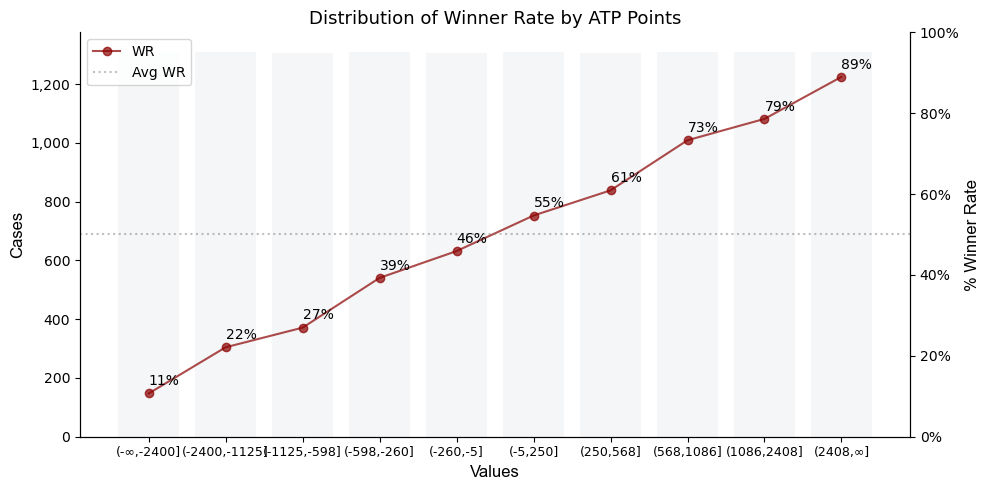

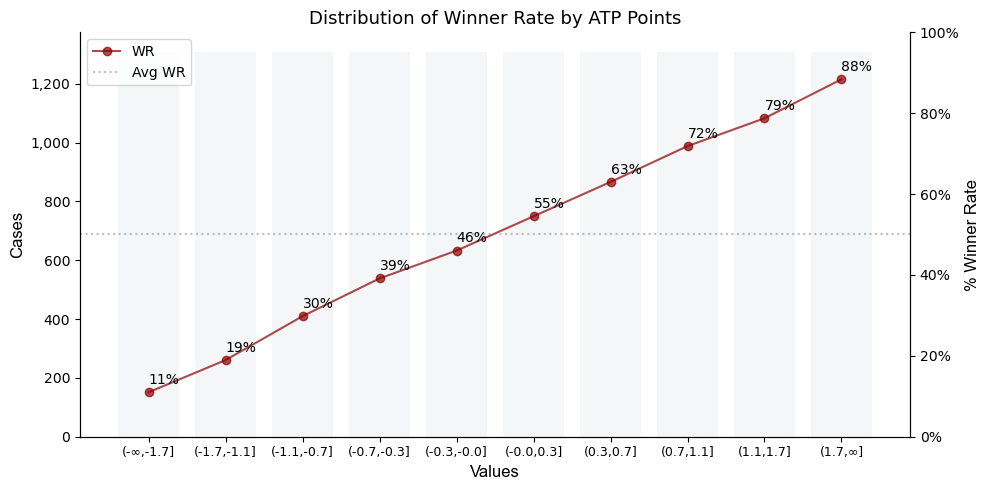

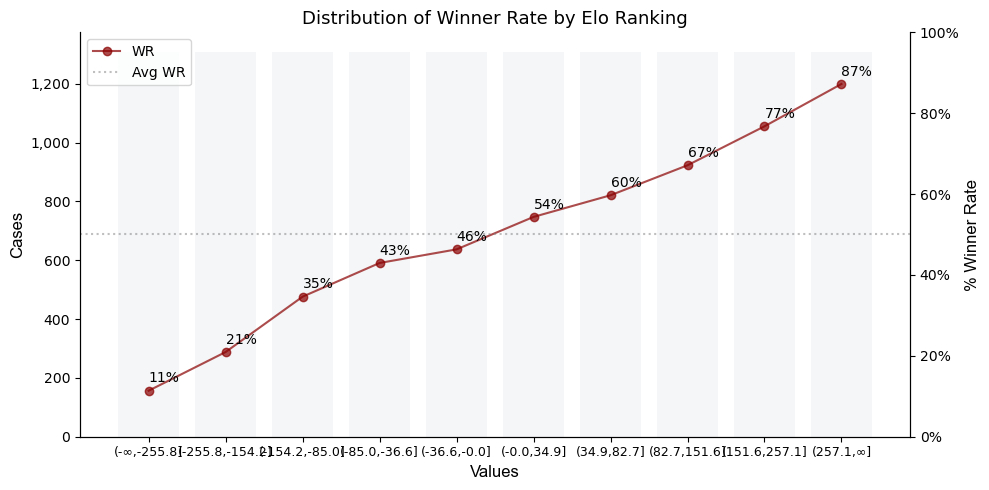

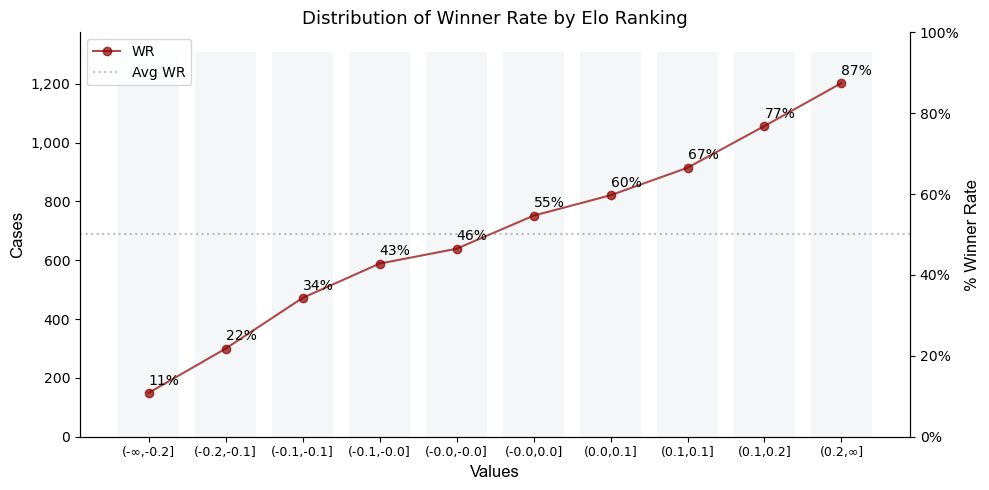

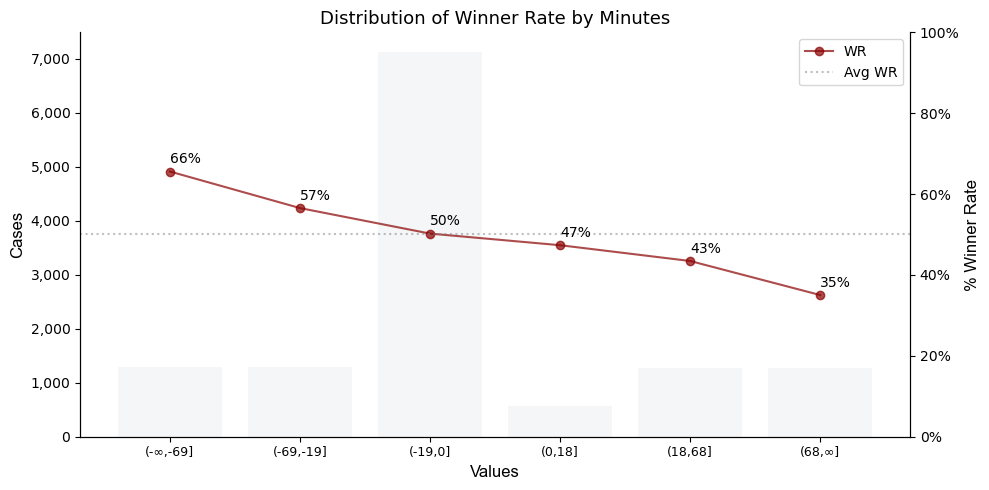

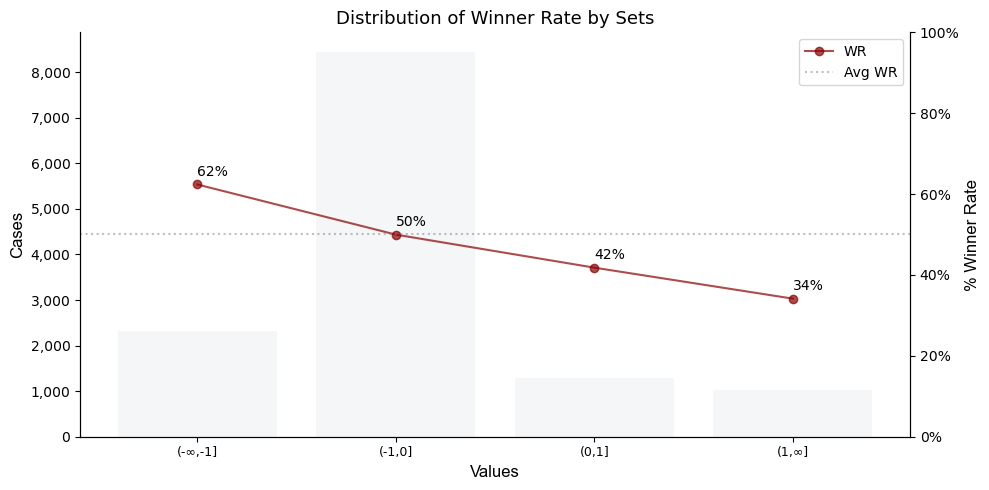

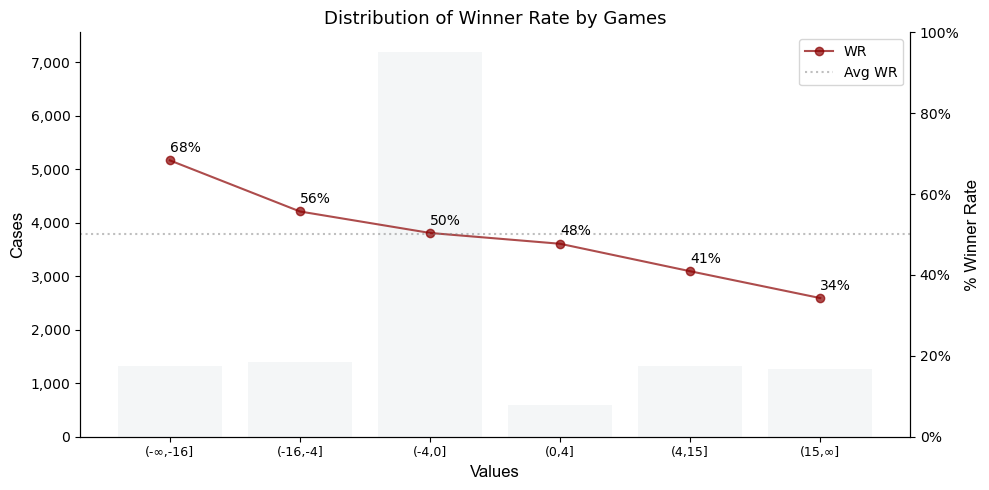

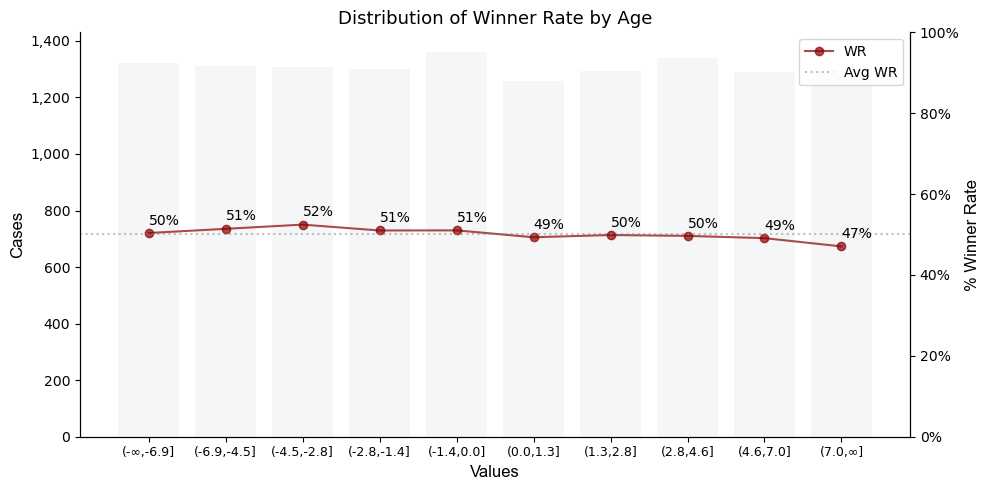

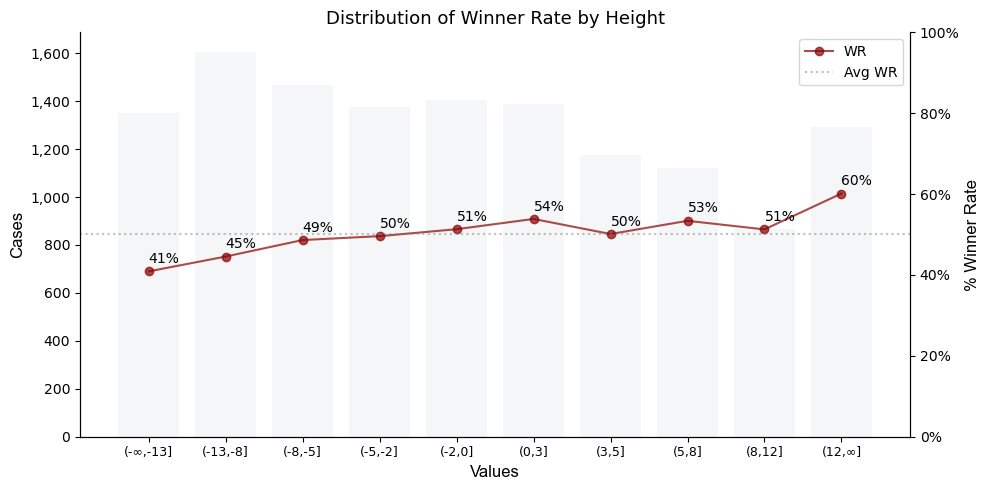

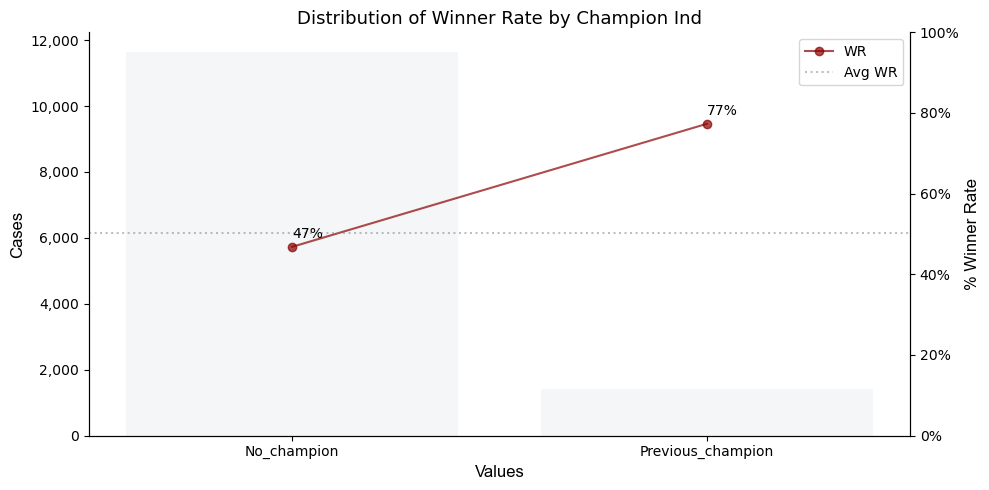

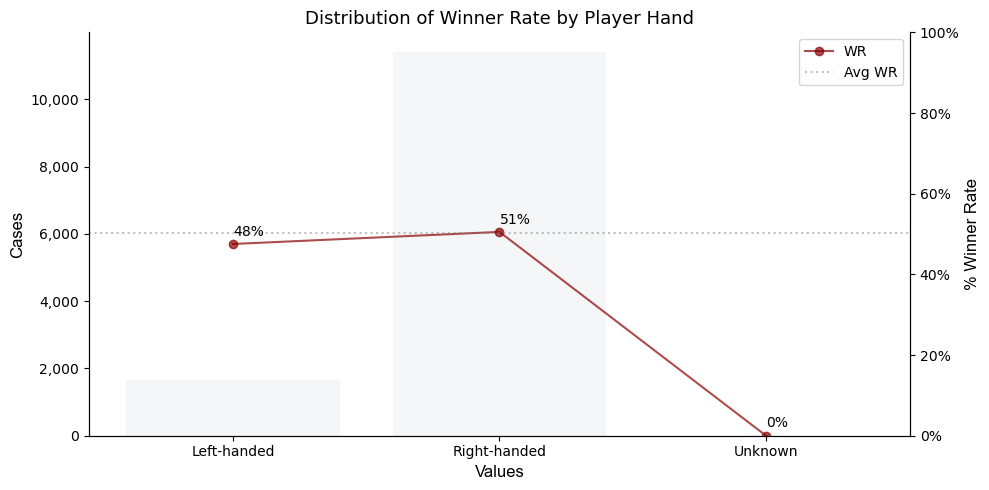

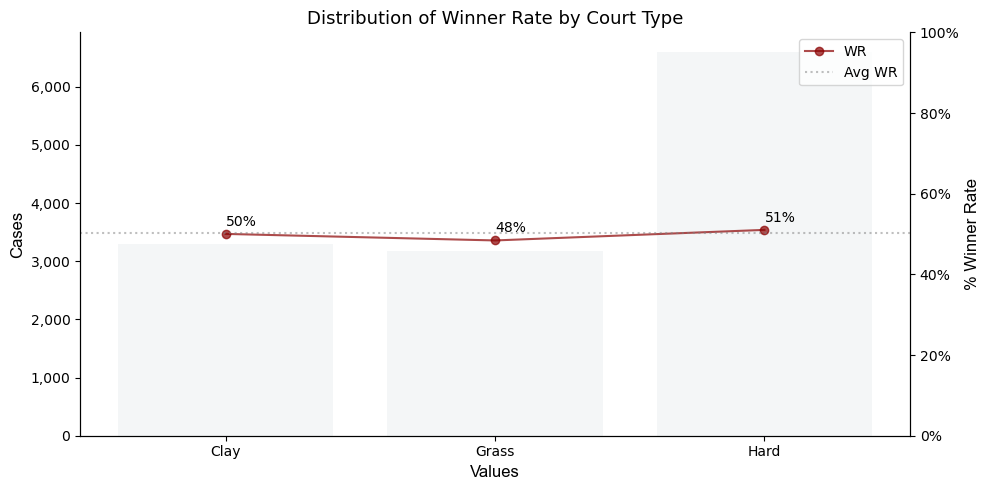

In [30]:
# WR Distribution for numerical variables
for col in numerical_variables:
    wr_distribution_numeric(full_db_prep,target,10,col)

# WR Distribution for categorical variables
for col in categorical_variables:
    wr_distribution_categoric(full_db_prep,target,col)

**Conclusion:** As can be seen, all the numerical variables showed a monotonic tendency consistent with the expected behavior of each driver. For example, the variable difference in ATP ranking points showed an increasing monotonic trend, indicating that the greater and more positive the difference in ranking points, the higher the probability of winning the match for the player. Furthermore, regarding the ranking variables, the log transformations presented a smoother monotonic trend. Hence, the log-transformed versions will be preferred over the original predictor for modelling purposes. Regarding the categorical variables no significant predictive power is visible.

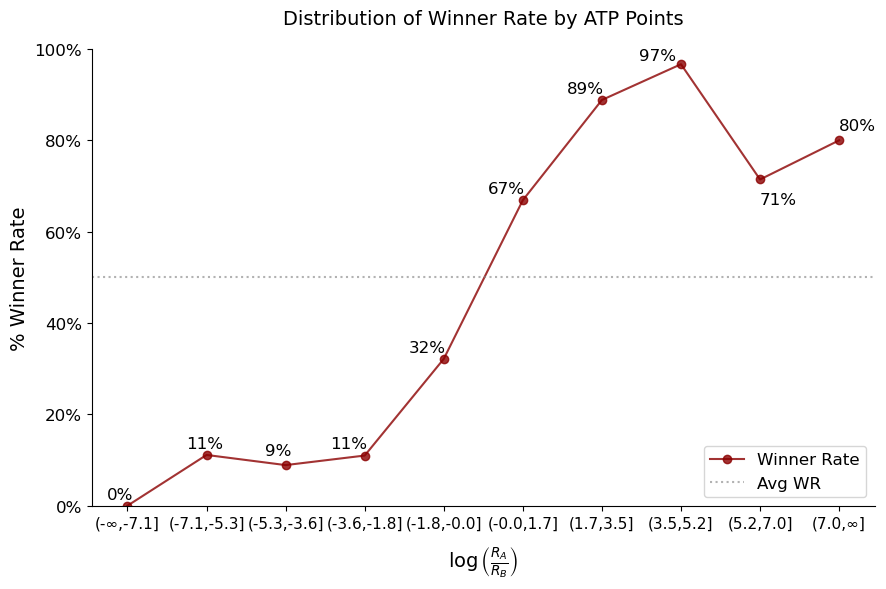

In [31]:
def numeric_binning_v2(db,target,bins,variable):
        db_ax = db.copy()
        #db_ax['metric_to_review'] = pd.qcut(db_ax[variable],bins, retbins=False, precision=4, duplicates='drop')
        db_ax['metric_to_review'] = pd.cut(db_ax[variable], bins = bins)  # equal-sized bins

        db_summary = db_ax.groupby('metric_to_review',observed=False)[target].aggregate(['count','mean']).reset_index()
        db_summary.columns = [variable,'Cases','WR']
    
        #Convert intervals to show -inf and inf at extremes
        intervals = db_summary[variable]
        
        # Replace first left bound and last right bound
        intervals = intervals.map(lambda x: pd.Interval(
                left=float('-inf') if x.left == intervals.min().left else x.left,
                right=float('inf') if x.right == intervals.max().right else x.right,
                closed=x.closed))


        # Show integer format or decimal format
        def format_number(x):
            y = int(x) if db[variable][0].is_integer() else round(x,1)
            return y
    
        #Build labels showing -inf / inf properly for bins, compute Winner Rate WR for each bin
        db_summary['UB'] = [ f"({ '-∞' if np.isneginf(x.left) else format_number(x.left) },{ '∞' if
                                    np.isposinf(x.right) else format_number(x.right) }]" for x in intervals ]
        db_summary['WR'] = db_summary['WR'].fillna(0)        
        db_summary['Winners'] = db_summary['Cases']*db_summary['WR']
        db_summary['Winners'] = [round(x,0) for x in db_summary['Winners']]       
        db_summary = db_summary[[variable,'Cases','Winners','WR','UB']]
        
        return db_summary


def wr_distribution_numeric_v2(db, Target, bins, variable):

    db_b = numeric_binning_v2(db, Target, bins, variable)
    y = db_b['WR']                     # Winner rate
    x = db_b.index
    avg_wr = np.mean(db[Target])
    labels = [str(x) for x in db_b['UB']]

    fig, ax = plt.subplots(figsize=(9, 6))

    # --- PLOT WINNER RATE ONLY ---
    ax.plot(x, y, marker='o', linestyle='-', color='darkred', 
            label='Winner Rate', alpha=0.8)

    # --- AXIS SETUP ---
    ax.set_ylabel('% Winner Rate', fontsize=14)
    ax.set_xlabel(r'$\log\left(\frac{R_A}{R_B}\right)$', fontsize=14, labelpad = 10)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    ax.tick_params(axis='y', labelsize=12)
    
    # --- AVERAGE WR LINE ---
    ax.axhline(y=avg_wr, color="gray", linestyle=':', 
               label='Avg WR', alpha=0.6)

    # --- PERCENTAGE LABELS TO THE RIGHT OF EACH POINT ---
    coordinates = [(-15,3),(-15,3),(-15,5),(-25,3),(-25,3),(-25,3),(-25,3),(-30,1),(0,-20),(0,5)]
    i = 0
    for xi, yi in zip(x, y):
        ax.annotate(f"{yi:.0%}",
                    (xi, yi),
                    xytext=(coordinates[i][0], coordinates[i][1]),
                    textcoords='offset points',
                    fontsize=12,
                    ha='left',
                    va='bottom')
        i+=1


    # --- LEGEND BOTTOM RIGHT ---
    ax.legend(loc='lower right', fontsize=12)

    # --- TITLE ---
    ax.set_title(f'Distribution of Winner Rate by ATP Points',
                 fontsize=14, pad=18)

    # --- CLEAN STYLE ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    fig.savefig("wr_distribution.png", dpi=200)
    plt.show()

wr_distribution_numeric_v2(full_db_prep,target[0],10,'Diff_log_ranking_points')

In [32]:
# Remove ranking predictors and keep their log transformation as the transformations seem more stable
numerical_variables.remove('Diff_Elo')
numerical_variables.remove('Diff_ranking')
numerical_variables.remove('Diff_ranking_points')

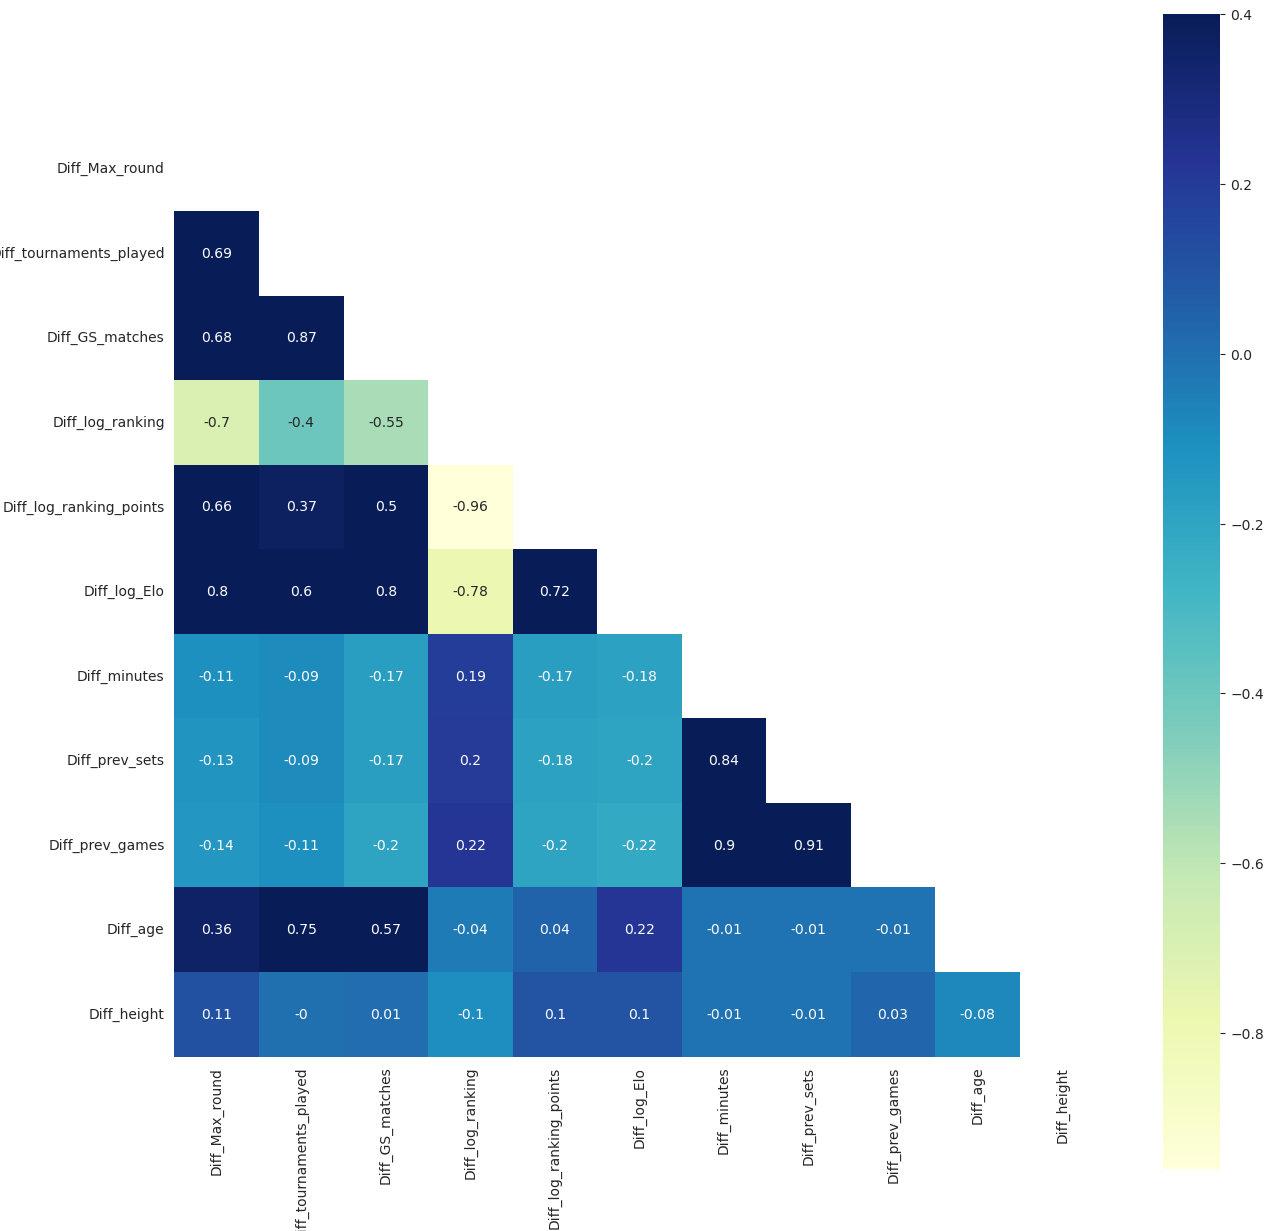

In [33]:
#Correlation with all numerical varaibles
corr_function(full_db_prep[numerical_variables])

In [34]:
# Save predictors for modelling stage
with open("predictors.json", "w") as f:
    json.dump(numerical_variables+categorical_variables, f)

# Save full description for variables
with open("predictors_description.json", "w") as f:
    json.dump(variables_index, f)